In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


##Introdução:
Este projeto teve como objetivo prever a sobrevivência de passageiros a bordo do Titanic utilizando técnicas de aprendizado de máquina. Empregamos uma variedade de métodos de pré-processamento de dados, modelagem e validação para maximizar a precisão das previsões. Os principais modelos utilizados foram Árvores de Decisão com e sem limitação de profundidade, e os resultados mostraram que a otimização de hiperparâmetros e a seleção de características foram cruciais para melhorar o desempenho do modelo.


###Alunos:

Alysson José da Silva Ramos (ajsr)

Antônio Gabriel dos Santos Clemente (agsc)

Thaís Neves de Souza (tns2)

In [ ]:
plt.style.use('default')

#carregar dados
trainData = pd.read_csv('./train.csv')
testData = pd.read_csv('./test.csv')
#result = pd.read_csv('./results.csv')
result = pd.read_csv('./gender_submission.csv')

testData = pd.concat([testData, result["Survived"]], axis=1)

#removendo colunas irrelevantes
cols_to_drop = ["Cabin", "Ticket", "Name", "PassengerId"]
trainData = trainData.drop(cols_to_drop, axis=1)
testData = testData.drop(cols_to_drop, axis=1)

In [ ]:
#exibir informações de valores nulos
def display_missing_data(data, dataset_name):
    print(f"{dataset_name} DataSet:")
    print(data.isna().sum())

display_missing_data(trainData, "Training")
display_missing_data(testData, "Test")

Training DataSet:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
Test DataSet:
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
Survived     0
dtype: int64


Em seguida, identificamos e preenchemos valores nulos utilizando IterativeImputer para as colunas 'SibSp', 'Parch' e 'Age'. A coluna 'Fare' foi preenchida com a média.

**Preencher valores nulos:**



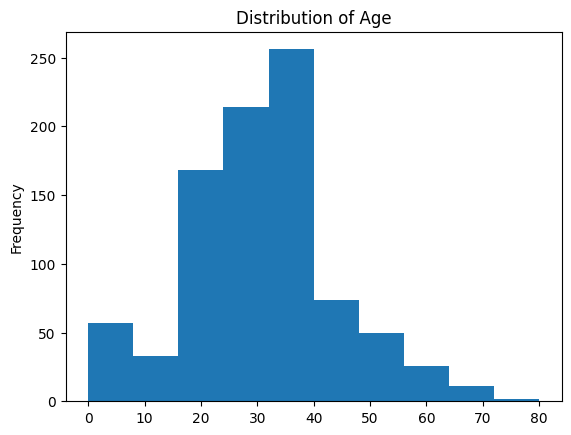

In [ ]:
#preenchendo valores nulos
def impute_missing_values(data, columns):
    imputer = IterativeImputer(min_value=0)
    imputed_values = imputer.fit_transform(data[columns])
    corrected_values = pd.DataFrame(imputed_values, columns=columns)
    for column in columns:
        data[column] = corrected_values[column]
    return data

columns_to_impute = ["SibSp", "Parch", "Age"]
trainData = impute_missing_values(trainData, columns_to_impute)
testData = impute_missing_values(testData, columns_to_impute)

trainData["Age"].plot(kind='hist')
plt.title('Distribution of Age')
plt.show()

Para permitir que os modelos interpretem variáveis categóricas, mapeamos as colunas 'Sex' e 'Embarked' para valores numéricos.

In [ ]:
#preenchendo valores faltantes na taxa de embarque pela média da coluna
trainData["Fare"].fillna(trainData["Fare"].mean(), inplace=True)
testData["Fare"].fillna(testData["Fare"].mean(), inplace=True)


In [ ]:
#converter variáveis categóricas
def map_categorical_to_numerical(data):
    data["Sex"] = data["Sex"].map({"male": 0, "female": 1})
    data["Embarked"] = data["Embarked"].map({"C": 0, "Q": 1, "S": 2}) #portos de embarque de cada passageiro
    return data

trainData = map_categorical_to_numerical(trainData)
testData = map_categorical_to_numerical(testData)

In [ ]:
#remover valores nuloes
trainData.dropna(inplace=True)
trainData.reset_index(drop=True, inplace=True)
testData.dropna(inplace=True)
testData.reset_index(drop=True, inplace=True)

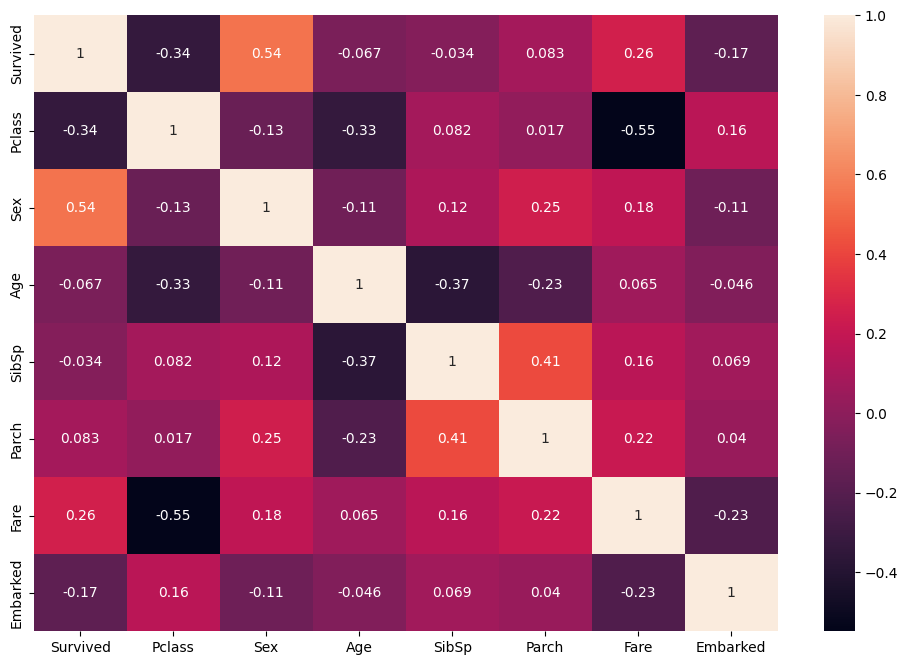

Valores não relacionados:
Age      0.066552
SibSp    0.034040
Parch    0.083151
Name: Survived, dtype: float64


In [ ]:
#análise de correlação
# por meio dela é possível ver quais variaveis são mais realacionadas aos sobreviventes
def plot_correlation_matrix(data):
    matrix = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True)
    plt.show()
    return matrix

correlation_matrix = plot_correlation_matrix(trainData)
corrSurvived = abs(correlation_matrix["Survived"])
print(f"Valores não relacionados:\n{corrSurvived[corrSurvived < 0.1]}")

In [ ]:
# Cria colunas para categorizar as idades
def categorize_age(data):
    bins = [0, 12, 60, 120]
    labels = ['child', 'adult', 'elderly']
    data['AgeCategory'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)
    return data.drop(["Age"], axis=1)

trainData = categorize_age(trainData)
testData = categorize_age(testData)

In [ ]:
# Mapear categorias de idade para números
def map_age_category(data):
    data["AgeCategory"] = data["AgeCategory"].map({"child": 0, "adult": 1, "elderly": 2})
    return data

trainData = map_age_category(trainData)
testData = map_age_category(testData)

a quantidade de filhos e conjugues não é um valor útil para prever a chance de sobrevivência. Logo iremos tratar esses dados

In [ ]:
#logo vou tratar os dados apenas em se umn passageiro viajou sozinho ou não
def add_family_features(data):
    data["FamilyCount"] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data["FamilyCount"] == 1).astype(int)
    return data.drop(["SibSp", "Parch", "FamilyCount"], axis=1)

trainData = add_family_features(trainData)
testData = add_family_features(testData)

### Árvore de Decisão

Árvore de decisão é um modelo de aprendizado de máquina para classificação e regressão. Seu objetivo é prever resultados ao seguir caminhos da raiz até as folhas, com base em testes realizados em cada nó. De forma que cada escolha de caminho é determinada pelo valor do atributo analisado, até que um nó folha seja alcançado e forneça a previsão.

Treinamos modelos de Árvore de Decisão com e sem limitação de profundidade. Utilizamos a precisão e a matriz de confusão para avaliar o desempenho dos modelos.

In [ ]:
#preparando dados para treinamento
trainX = trainData.drop(["Survived"], axis=1)
trainY = trainData["Survived"]

testX = testData.drop(["Survived"], axis=1)
testY = testData["Survived"]

Sem limitação de profundidade - Accuracy: 0.84688995215311
Sem limitação de profundidade - Confusion Matrix:
[[235  31]
 [ 33 119]]
Com limitação de profundidade - Accuracy: 0.8899521531100478
Com limitação de profundidade - Confusion Matrix:
[[244  22]
 [ 24 128]]


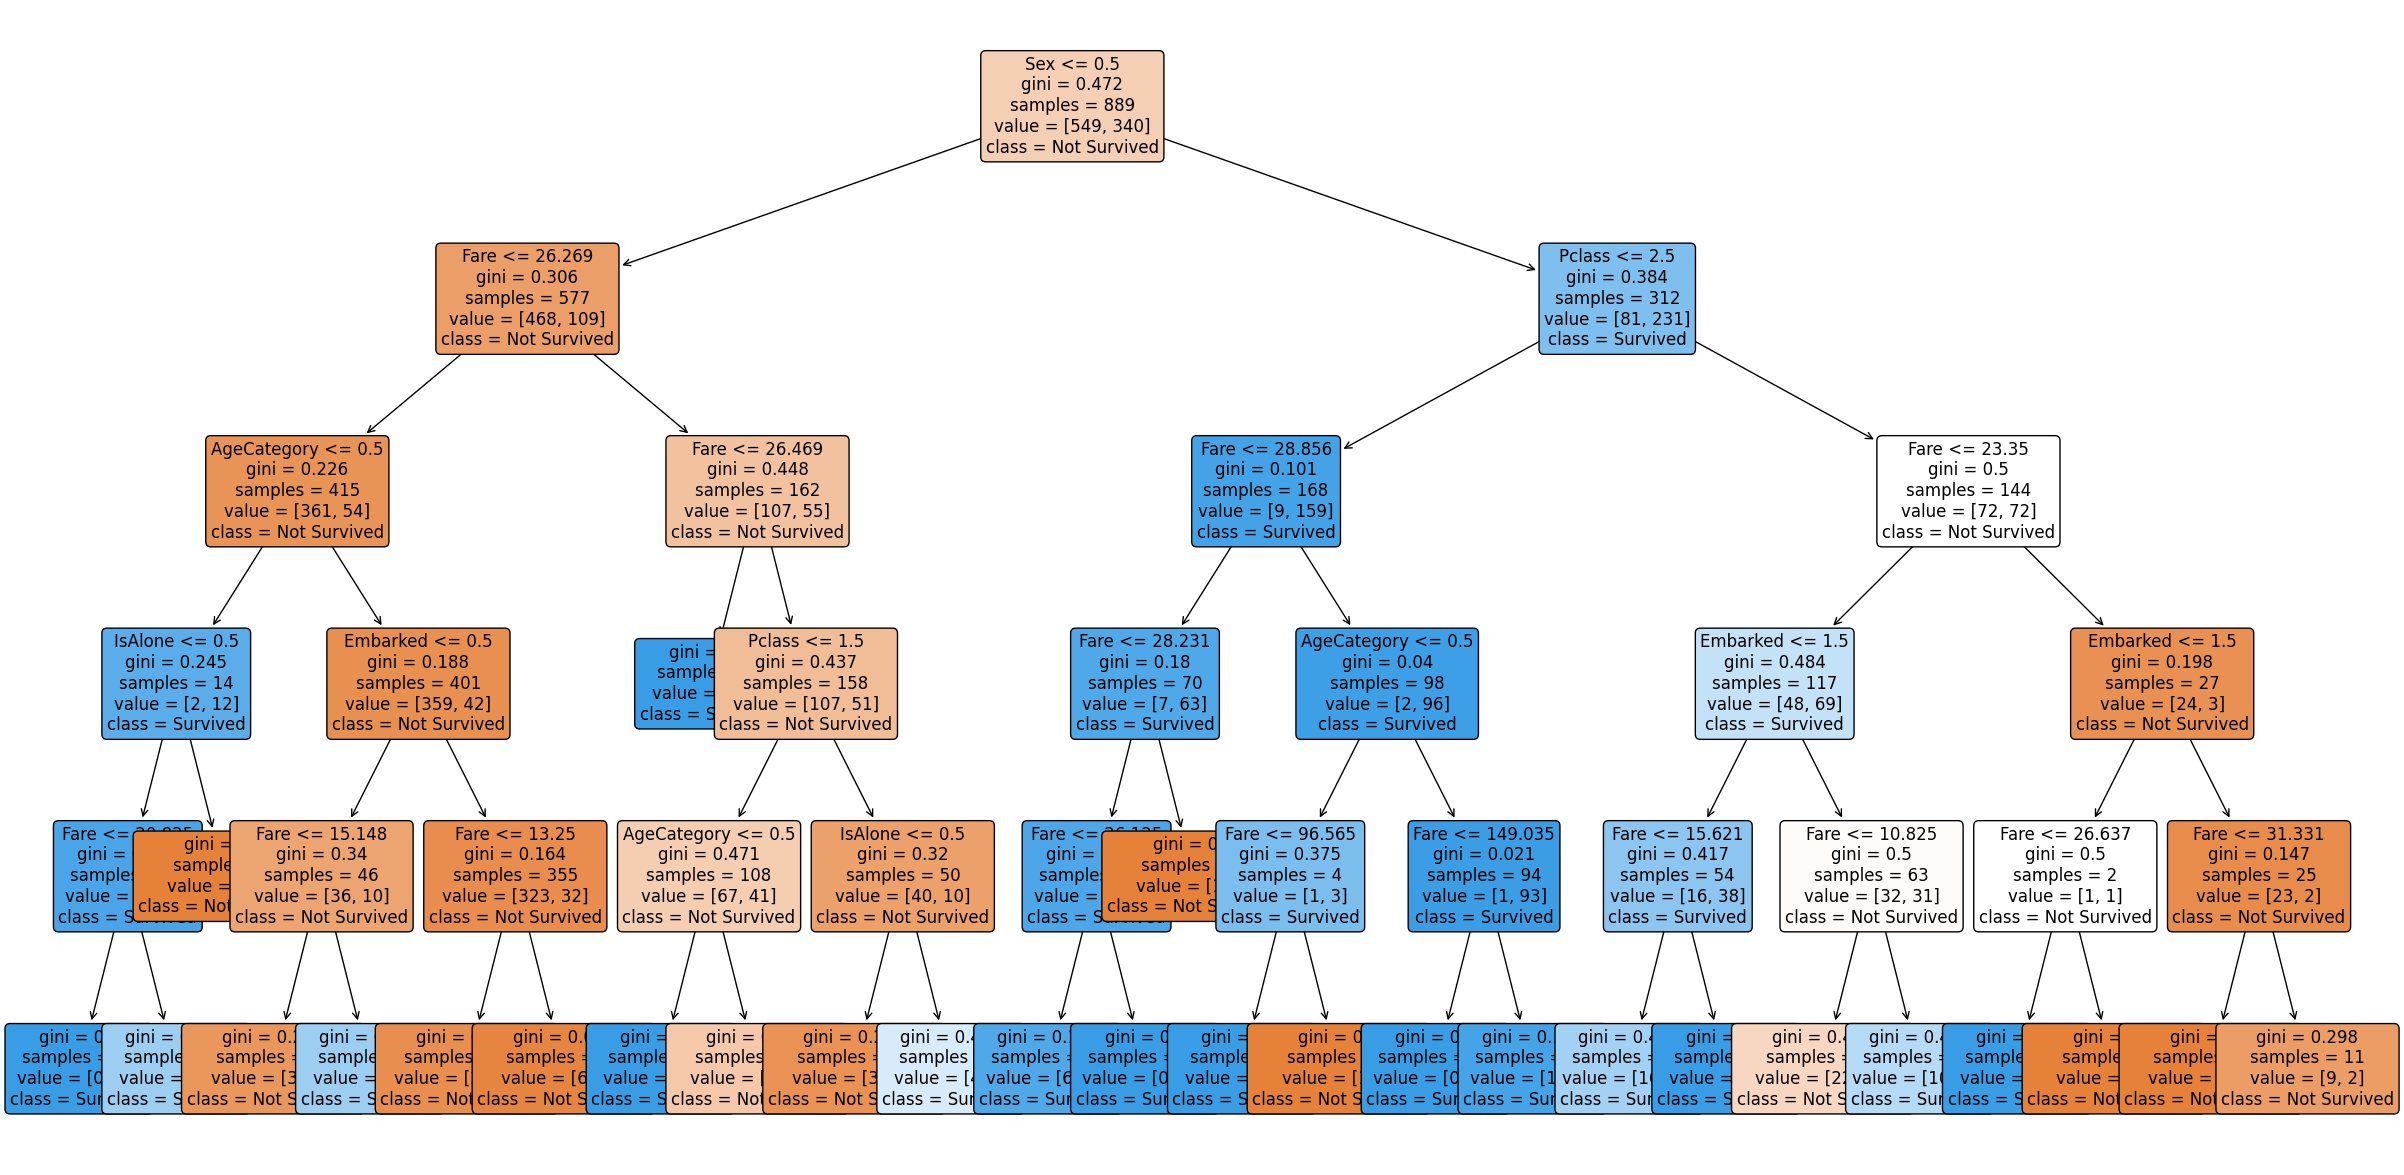

In [ ]:
#treinando e avaliando modelos
def evaluate_model(model, trainX, trainY, testX, testY, model_name):
    model.fit(trainX, trainY)
    y_pred = model.predict(testX)
    accuracy = accuracy_score(testY, y_pred)
    conf_matrix = confusion_matrix(testY, y_pred)
    print(f'{model_name} - Accuracy: {accuracy}')
    print(f'{model_name} - Confusion Matrix:\n{conf_matrix}')
    return model, accuracy, conf_matrix

model_no_limit = DecisionTreeClassifier(random_state=42)
evaluate_model(model_no_limit, trainX, trainY, testX, testY, 'Sem limitação de profundidade')

model_with_limit = DecisionTreeClassifier(max_depth=5)
evaluate_model(model_with_limit, trainX, trainY, testX, testY, 'Com limitação de profundidade')

plt.figure(figsize=(30, 15))
plot_tree(
    model_with_limit,
    filled=True,
    feature_names=trainX.columns,
    class_names=['Not Survived', 'Survived'],
    rounded=True,
    proportion=False,
    fontsize=12
)
plt.show()


### Stratified K-fold:





Na Validação Cruzada Estratificada, cada grupo de teste tem a mesma variedade de tipos de dados que o conjunto completo. Isso garante que o modelo seja testado de forma justa e precisa.

In [ ]:
#variando parâmetros
totalDataSet = pd.concat([trainData,testData])
X = totalDataSet.drop(["Survived"], axis=1)
Y = totalDataSet["Survived"]

accuracies = []
conf_matrices = []

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True)

for trainIndex, textIndex in stratified_cv.split(X, Y):
    f_trainX, f_testX = X.iloc[trainIndex], X.iloc[textIndex]
    f_trainY, f_testY = Y.iloc[trainIndex], Y.iloc[textIndex]

    model_with_limit = DecisionTreeClassifier(max_depth=5)
    model_with_limit.fit(f_trainX, f_trainY)

    y_pred_with_limit = model_with_limit.predict(f_testX)
    accuracies.append(accuracy_score(f_testY, y_pred_with_limit))
    conf_matrices.append(confusion_matrix(f_testY, y_pred_with_limit))

#cálculo das métricas médias após a validação cruzada estratificada
mean_accuracy = np.mean(accuracies)
mean_conf_matrix = np.mean(conf_matrices, axis=0)

print(f'Media da Accuracy com limitaçao de profundidade: {mean_accuracy}')
print(f'Media da Confusion Matrix com limitacao de profundidade:\n{mean_conf_matrix}')


Media da Accuracy com limitaçao de profundidade: 0.8714661753092919
Media da Confusion Matrix com limitacao de profundidade:
[[150.4  12.6]
 [ 21.   77.4]]


### Técnica de otimização de hiperparâmetros

Tal técnica é utilizada em aprendizado de máquina para encontrar a combinação ideal de parâmetros para um modelo.

GridSearchCV realiza uma busca exaustiva em um espaço de hiperparâmetros definido por uma grade. Isso significa que todas as combinações possíveis de parâmetros são avaliadas para encontrar a melhor combinação com base em uma métrica de desempenho especificada.

RandomizedSearchCV faz uma busca aleatória sobre um espaço de hiperparâmetros distribuído de forma definida. Em vez de testar todas as combinações possíveis, ele avalia um número fixo de configurações aleatórias do espaço de parâmetros.

Como a base de dados do titanic é relativamente pequena em termos de volume de dados e complexidade, o espaço de hiperparâmetros pode ser relativamente pequeno. Logo, vamos usar o GridSearchCV.

In [ ]:

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 20, 40, 60, 80],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=42)

#config
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='accuracy', verbose=1)

In [ ]:
grid_search.fit(trainX, trainY)

#melhores parâmetros encontrados pelo GridSearchCV
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor precisão:", grid_search.best_score_)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Melhores parâmetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2}
Melhor precisão: 0.8414206817749001


In [ ]:
#avaliação do modelo com os melhores parâmetros no conjunto de teste
best_model_with_limit = grid_search.best_estimator_
y_pred_with_limit = best_model_with_limit.predict(testX)
accuracy_with_limit = accuracy_score(testY, y_pred_with_limit)
conf_matrix_with_limit = confusion_matrix(testY, y_pred_with_limit)

print(f'Melhores parâmetros encontrados, incluindo max_depth -> Accuracy: {accuracy_with_limit}')
print(f'Melhores parâmetros encontrados, incluindo max_depth -> Confusion Matrix:\n{conf_matrix_with_limit}')

Melhores parâmetros encontrados, incluindo max_depth -> Accuracy: 0.8588516746411483
Melhores parâmetros encontrados, incluindo max_depth -> Confusion Matrix:
[[243  23]
 [ 36 116]]


### Recursive Feature Elimination (RFE)

Implementamos Recursive Feature Elimination (RFE), que seleciona um subconjunto das características mais relevantes para o modelo, removendo iterativamente as características menos importantes. Para simplificar a árvore, utilizamos Cost Complexity Pruning, tornando-a menos propensa ao sobreajuste e mais fácil de interpretar.

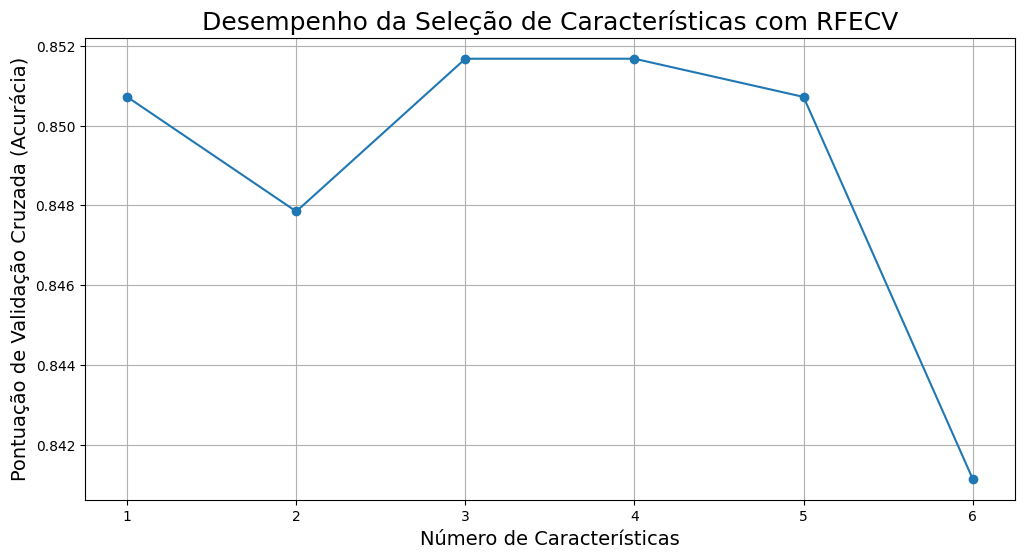

Número ótimo de características: 3
Características selecionadas: ['Pclass', 'Sex', 'Fare']


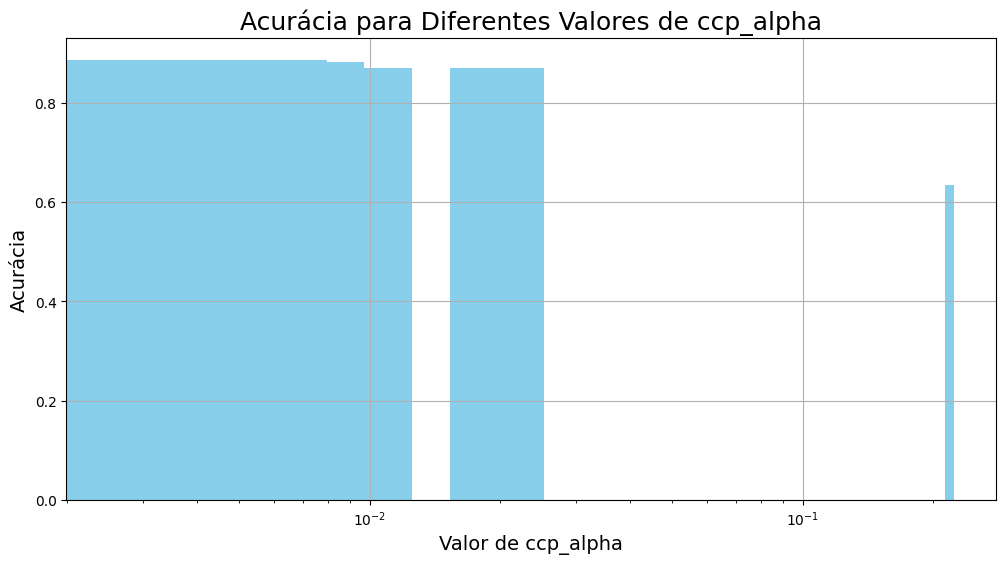

Melhor ccp_alpha: 0.00297098467469125
Acurácia do melhor modelo no conjunto de teste: 0.8854961832061069


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#seleção de características
dt = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=dt, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train, y_train)

#fráfico de RFE com Validação Cruzada
plt.figure(figsize=(12, 6))
plt.title('Desempenho da Seleção de Características com RFECV', fontsize=18)
plt.xlabel('Número de Características', fontsize=14)
plt.ylabel('Pontuação de Validação Cruzada (Acurácia)', fontsize=14)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.grid(True)
plt.show()

#resultados da seleção de características
print(f"Número ótimo de características: {rfecv.n_features_}")
selected_features = [f for f, s in zip(X_train.columns, rfecv.support_) if s]
print(f"Características selecionadas: {selected_features}")

#reduzir os dados para as características selecionadas
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

#encontrar o melhor valor de ccp_alpha usando a curva de complexidade de custo
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train_reduced, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#treinamento com diferentes valores de ccp_alpha
acc_scores = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    acc_scores.append(accuracy_score(y_test, y_pred))

#melhor ccp_alpha
best_alpha = ccp_alphas[np.argmax(acc_scores)]
best_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
best_clf.fit(X_train_reduced, y_train)

#avaliando a precisão do melhor modelo
y_pred_best = best_clf.predict(X_test_reduced)
accuracy_best = accuracy_score(y_test, y_pred_best)

#gráfico de acurácia para diferentes valores de ccp_alpha
plt.figure(figsize=(12, 6))
plt.title('Acurácia para Diferentes Valores de ccp_alpha', fontsize=18)
plt.xlabel('Valor de ccp_alpha', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.bar(ccp_alphas, acc_scores, width=0.01, color='skyblue')
plt.xscale('log')  #escala logarítmica para melhor visualização
plt.grid(True)
plt.show()

print(f"Melhor ccp_alpha: {best_alpha}")
print(f"Acurácia do melhor modelo no conjunto de teste: {accuracy_best}")

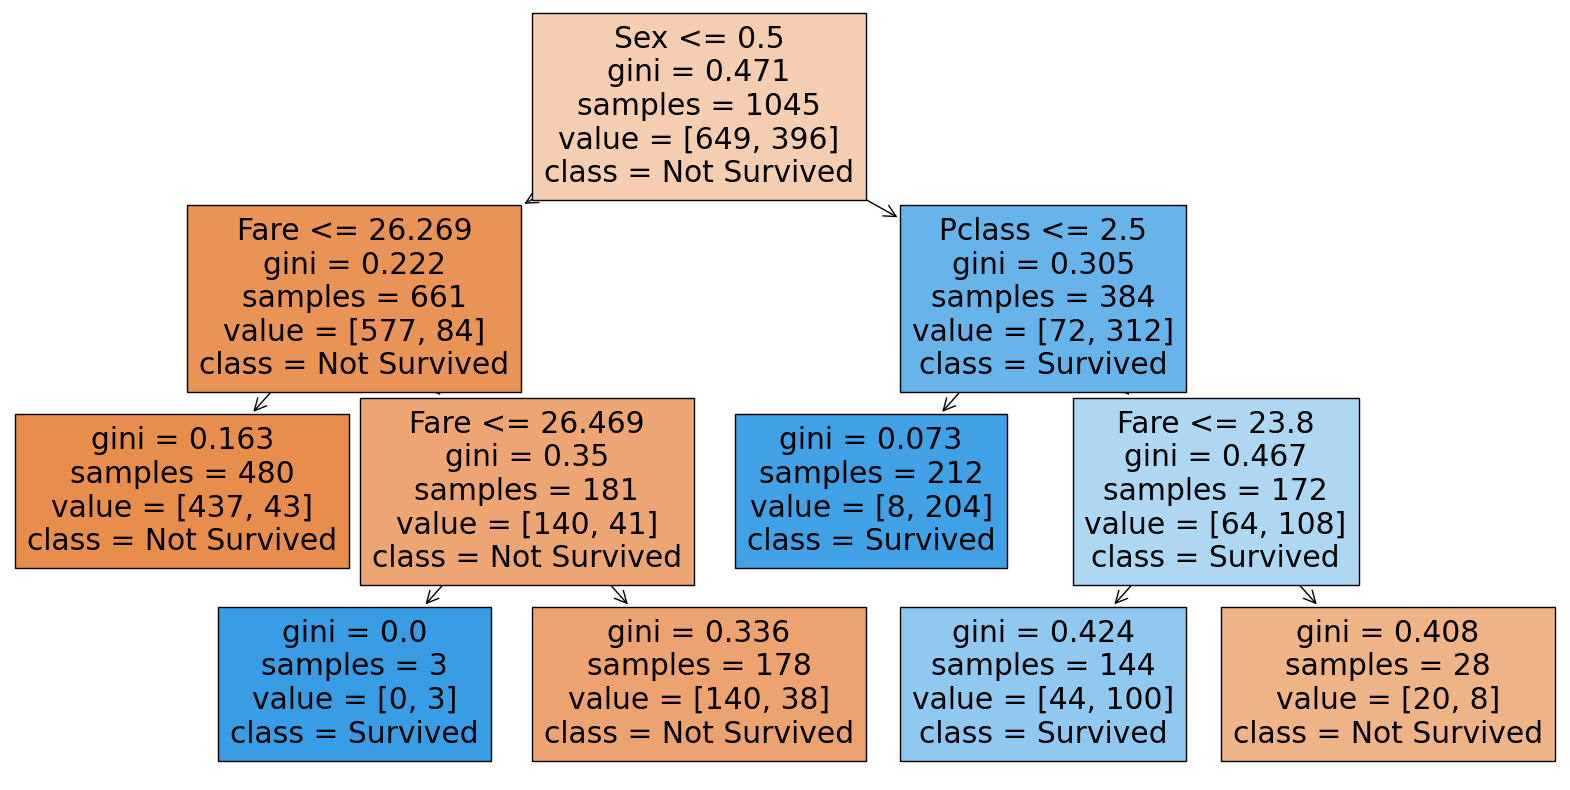

In [ ]:
#visualizando a melhor árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=selected_features, class_names=['Not Survived', 'Survived'])
plt.show()

É possível notar notar diferentes configurações de modelo para prever a sobrevivência de um passageiro. Primeiro não teve limitações de profundidade e depois usandos limite com profundidade máxima, também utilizamos validação cruzada que garantiu a consistência e generalização.
O GridSearchCV identificou os melhores parâmetros.
Pruning de Complexidade de Custo ajusta a complexidade da árvore.
O que possibiliou o ajuste de parâmetros e controlou a complexidade do modelo.

### Random Forest

Random Forest é um algoritmo de aprendizado de máquina que combina a ideia de várias árvores de decisão para criar um modelo mais robusto e preciso. É amplamente utilizado para tarefas de classificação e regressão.

In [ ]:
#treina e avalia o modelo Random Forest
def train_and_evaluate_rf(trainX, trainY, testX, testY, random_state=42):
    # Criar e treinar o modelo Random Forest
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(trainX, trainY)

    # Fazer previsões
    y_pred_rf = rf.predict(testX)

    # Avaliar o modelo
    accuracy_rf = accuracy_score(testY, y_pred_rf)
    conf_matrix_rf = confusion_matrix(testY, y_pred_rf)
    precision_rf = precision_score(testY, y_pred_rf)
    recall_rf = recall_score(testY, y_pred_rf)
    f1_rf = f1_score(testY, y_pred_rf)

    return rf, accuracy_rf, conf_matrix_rf, precision_rf, recall_rf, f1_rf

#função para plotar a matriz de confusão
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

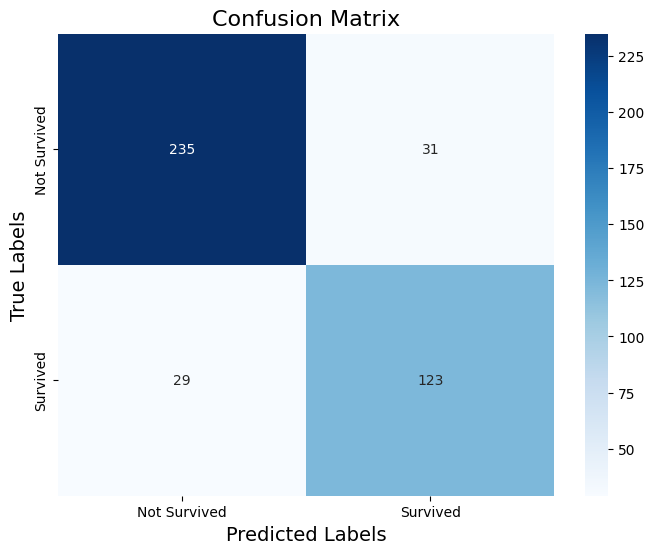

In [ ]:
model_rf, accuracy_rf, conf_matrix_rf, precision_rf, recall_rf, f1_rf = train_and_evaluate_rf(trainX, trainY, testX, testY)

# Plotar a matriz de confusão
class_names = ['Not Survived', 'Survived']
plot_confusion_matrix(conf_matrix_rf, class_names)


Random Forest Accuracy: 0.8740458015267175


<ipython-input-22-9f04be268e6b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


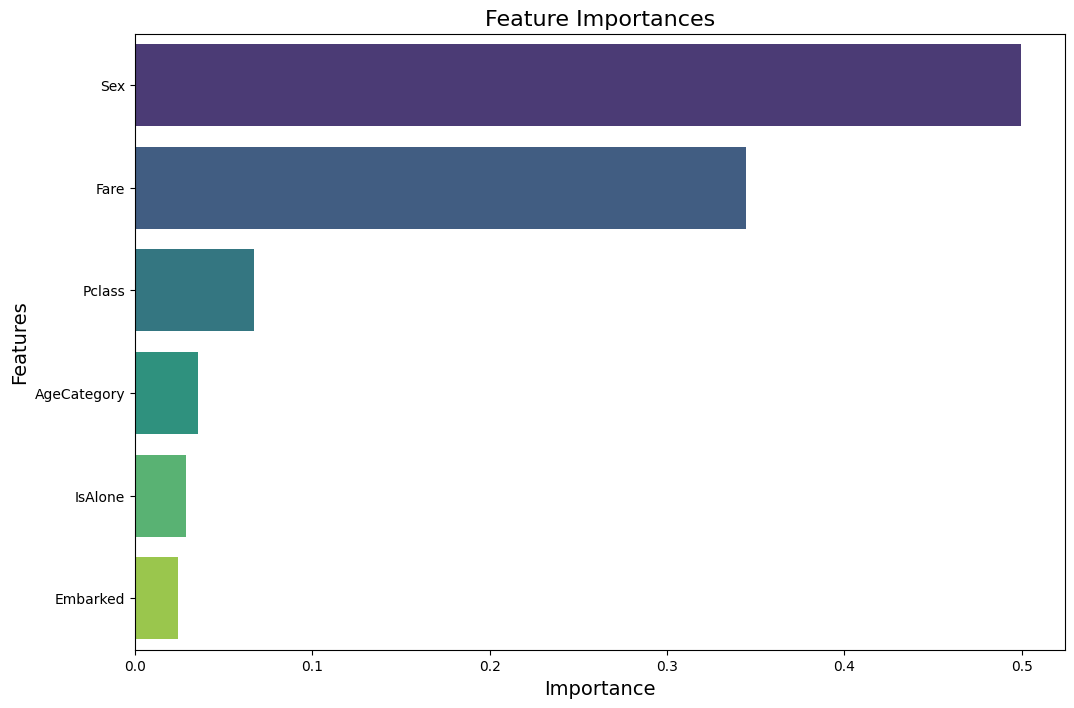

In [ ]:
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importances', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.show()

# Treinar o modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Avaliar o modelo
accuracy_rf = accuracy_score(y_test, model_rf.predict(X_test))
print(f"Random Forest Accuracy: {accuracy_rf}")

# Plotar a importância das características
plot_feature_importances(model_rf, trainX.columns)

In [ ]:
# Imprimir os resultados
print(f'Random Forest - Accuracy: {accuracy_rf:.4f}')
print(f'Random Forest - Precision: {precision_rf:.4f}')
print(f'Random Forest - Recall: {recall_rf:.4f}')
print(f'Random Forest - F1 Score: {f1_rf:.4f}')
print(f'Random Forest - Confusion Matrix:\n{conf_matrix_rf}')

Random Forest - Accuracy: 0.8740
Random Forest - Precision: 0.7987
Random Forest - Recall: 0.8092
Random Forest - F1 Score: 0.8039
Random Forest - Confusion Matrix:
[[235  31]
 [ 29 123]]


### Conclusão RF
O modelo Random Forest apresenta um bom desempenho geral com uma alta acurácia 88%. A precisão é bastante alta 80%, indicando que, quando o modelo prevê sobrevivência, ele é geralmente correto. O recall é também forte 80%, mostrando que o modelo é eficaz em identificar a maioria dos passageiros sobreviventes. O F1 Score de 0,80 sugere que há um bom equilíbrio entre precisão e recall.

Em conclusão, nosso estudo demonstrou a importância de uma abordagem estruturada para a limpeza e pré-processamento de dados, seleção de características e otimização de hiperparâmetros. Nossos resultados sugerem que esses passos são essenciais para maximizar a precisão das previsões de sobrevivência no conjunto de dados do Titanic.